# Part III: Role of energy-water storage in Central Asia

This tutorial demonstrates the functionality of seasonal pumped hydropower storage (SPHS) in improving water and energy security in Central Asia. We use the open MESSAGEix energy-water model of Central Asia (MESSAGEix-CAS) developed in previous tutorials (part I and II) and run the module for SPHS. This tutorial includes instructions for:
- loading the MESSAGEix-CAS Baseline scenario and cloning it
- adding SPHS for water and energy storage
- postprocessing and visualization of some output results

The schematic below shows how the proposed “dual water and energy storage scheme” using SPHS can resolve the mismatch between water availability for electricity generation and irrigation. The size of the arrows indicates the amount of water flow in each season. Red arrows show the discharge of water from dams. HPP: hydropower plant.

<img src='_static/water-model.jpg' style="width: 500px;">

For more details please refer to: [Zakeri et al., 2022](https://doi.org/10.1016/j.est.2022.104587), and if you have any questions please contact us (hunt@iiasa.ac.at).

## 1. Importing software packages and loading Baseline

For running this tutorial, you need to have:
- The `message_ix` modeling framework installed sucessfully with a version >= 3.4.0 (see instructions [here](https://docs.messageix.org/en/stable/#getting-started) ).
- Updated your code by pulling modifications done for this study from [this fork](https://github.com/behnam-zakeri/message_ix/tree/central-asia-paper).
- You have run Part I of the tutorials, i.e, generating a Baseline scenario

*Notice*: If you have installed `message_ix` using Anaconda/miniconda, and you are a proficient user of `git` to pull the changes from the abovementioned fork automatically, you can update your code manually. For doing so, you need to copy the following folder and file from the fork and replace the ones on your machine:
- `message_ix/model/MESSAGE` [folder](https://github.com/behnam-zakeri/message_ix/tree/central-asia-paper/message_ix/model/MESSAGE), and
- `message_ix/models.py` [file](https://github.com/behnam-zakeri/message_ix/tree/central-asia-paper/message_ix/models.py).

In [1]:
# Importing required software packages
import pandas as pd
import os
import ixmp
import message_ix
from postprocessor import monthly_plot, yearly_plot, cost_emission_plot, compare_three_scenario
from utilities import add_share_activity

<IPython.core.display.Javascript object>

In [2]:
# Getting path to this project on your machine
path = os.path.dirname(os.path.realpath("__file__")).strip("\scripts")

In [3]:
# Loading modeling platform (this will link you to your database)
mp = ixmp.Platform()

In [4]:
# Loading Baseline scenario
model = 'MESSAGEix-CAS'
scenario = 'baseline'
base = message_ix.Scenario(mp, model, scenario)
base.version

Existing index sets of 'map_tec_storage' ['node', 'technology', 'mode', 'storage_tec', 'mode', 'level', 'commodity', 'lvl_temporal'] do not match ['node', 'technology', 'mode', 'technology', 'mode', 'level', 'commodity', 'lvl_temporal']
Existing index sets of 'STORAGE' ['node', 'technology', 'level', 'commodity', 'year', 'time'] do not match ('node', 'technology', 'mode', 'level', 'commodity', 'year', 'time')


17

### 1.1. Water flow model
The water flow model is a monthly representation of water flow in Amu Darya and Siri Darya rivers in Central Asia. The model includes:

- Upstream water supply
- Upstream dams
- Spillage from dams
- Potential seasonal pumped hydro plants
- Downstream dams
- Downstream spillage
- Downstream water demand

Water demand is an input data to the model, and the result of optimization shows the most optimal solution for cascading water through different water supply levels.

In [5]:
# Loading input data of water demand and editing is needed
parname = 'demand'  
commodity = 'water-amu'    # Water from Amu Darya
node = 'UZB'
yr = 2020

# Notice the syntax for filtering
table = base.par(parname, {'commodity': commodity, 'node':node, 'year': yr})

# See the table (Notice: 'time' labeled as 1 is January and 12 is Decmeber)
table

,node,commodity,level,year,time,value,unit
0,UZB,water-amu,useful,2020,1,0.177778,1000 m3/s
1,UZB,water-amu,useful,2020,2,0.311111,1000 m3/s
2,UZB,water-amu,useful,2020,3,0.509179,1000 m3/s
3,UZB,water-amu,useful,2020,4,0.458696,1000 m3/s
4,UZB,water-amu,useful,2020,5,0.629227,1000 m3/s
5,UZB,water-amu,useful,2020,6,0.888406,1000 m3/s
6,UZB,water-amu,useful,2020,7,1.082367,1000 m3/s
7,UZB,water-amu,useful,2020,8,0.874638,1000 m3/s
8,UZB,water-amu,useful,2020,9,0.440821,1000 m3/s
9,UZB,water-amu,useful,2020,10,0.325121,1000 m3/s


## 2. Modeling of water-energy storage
The energy-water storage solution is already represented in the model with a combination of three sections:

- Charger, to charge water to the reservoir (technology 'pump')
- Discharger, to discharge water and generate electricity (technology 'turbine')
- Storage reservoir, to store water over different months (technology 'hydro_pump')

These three sections are linked (mapped) together through `map_tec_storage`. Traditional reservoir hydropower plants (HPP) are also represented with three sections: inflow, turbne, and dam itself. For checking this, first, we need to load and clone the Baseline scenario.

In [6]:
# Cloning the baseline scenario (i.e., making a new version of it for our work)
sphs = base.clone(scenario='baseline_sphs', keep_solution=False)

Existing index sets of 'map_tec_storage' ['node', 'technology', 'mode', 'storage_tec', 'mode', 'level', 'commodity', 'lvl_temporal'] do not match ['node', 'technology', 'mode', 'technology', 'mode', 'level', 'commodity', 'lvl_temporal']
Existing index sets of 'STORAGE' ['node', 'technology', 'level', 'commodity', 'year', 'time'] do not match ('node', 'technology', 'mode', 'level', 'commodity', 'year', 'time')


In [7]:
# Loading the content of map_tec_storage
sphs.set('map_tec_storage')

,node,technology,mode,storage_tec,storage_mode,level,commodity,lvl_temporal
0,TJK,pump,M1,hydro_pump,M1,storage,water,subannual
1,KGZ,pump,M1,hydro_pump,M1,storage,water,subannual
2,TJK,turbine,M1,hydro_pump,M1,storage,water,subannual
3,KGZ,turbine,M1,hydro_pump,M1,storage,water,subannual
4,TJK,inflow_dam,M1,hydro_dam,M1,storage2,water,subannual
5,KGZ,inflow_dam,M1,hydro_dam,M1,storage2,water,subannual
6,TJK,turbine_dam,M1,hydro_dam,M1,storage2,water,subannual
7,KGZ,turbine_dam,M1,hydro_dam,M1,storage2,water,subannual


### 2.1 Water supply
Water supply is represented as bounded flow in different months. This can be modeled in `message_ix` using parameter `bound_activity_up`. In fact, we specify upper bound of water flow in each month, and the model can find the best solution for storing or cascading water for meeting the water and energy demand. Water flow is represented as technology in the model. For the full list of technology names refer to "Definitions" in the Excel files.

In [8]:
# Checking the data of water supply
tec = "inflow_up_amu"    # inflow upstream Amu Darya
node = "TJK"
table = sphs.par("bound_activity_up", {"technology": tec, "node_loc": node, "year_act": 2020})
table

,node_loc,technology,year_act,mode,time,value,unit
0,TJK,inflow_up_amu,2020,M1,1,0.063002,1000 m3/s
1,TJK,inflow_up_amu,2020,M1,2,0.042888,1000 m3/s
2,TJK,inflow_up_amu,2020,M1,3,0.036376,1000 m3/s
3,TJK,inflow_up_amu,2020,M1,4,0.216540,1000 m3/s
4,TJK,inflow_up_amu,2020,M1,5,0.622320,1000 m3/s
5,TJK,inflow_up_amu,2020,M1,6,0.849944,1000 m3/s
6,TJK,inflow_up_amu,2020,M1,7,1.996079,1000 m3/s
7,TJK,inflow_up_amu,2020,M1,8,0.500573,1000 m3/s
8,TJK,inflow_up_amu,2020,M1,9,0.307604,1000 m3/s
9,TJK,inflow_up_amu,2020,M1,10,0.221020,1000 m3/s


### 2.2. Activating seasonal pumped hydro
By default, SPHS is deactivated by adding a bound. This means that the model does not invest on this technology in Baseline. However, to investigate the role of SPHS, we remove the bound and let the model decide if this technology can be useful for the system or not. For removing the bound, we need to check out the scenario for editing.

In [9]:
# Checking out the scenario (= opening the scenario for editing)
sphs.check_out()

In [10]:
# Loading upper bound on a technology
tec = 'turbine'    # Turbine section of SPHS
node = 'TJK'
parname = 'bound_activity_up'
table = sphs.par(parname, {'technology': tec, 'node_loc': node})
# see the table
table

,node_loc,technology,year_act,mode,time,value,unit
0,TJK,turbine,2020,M1,1,0.0,1000 m3/s
1,TJK,turbine,2020,M1,2,0.0,1000 m3/s
2,TJK,turbine,2020,M1,3,0.0,1000 m3/s
3,TJK,turbine,2020,M1,4,0.0,1000 m3/s
4,TJK,turbine,2020,M1,5,0.0,1000 m3/s
...,...,...,...,...,...,...,...
103,TJK,turbine,2060,M1,8,0.0,1000 m3/s
104,TJK,turbine,2060,M1,9,0.0,1000 m3/s
105,TJK,turbine,2060,M1,10,0.0,1000 m3/s
106,TJK,turbine,2060,M1,11,0.0,1000 m3/s


In [11]:
# Removing the bound on SPHS
sphs.remove_par('bound_activity_up', table)

In [12]:
# Committing the changes (saving and checking in the scenario)
# You can add a commit message as you wish:
sphs.commit('bound of SPHS removed')

### 2.3. Solving the scenario
After committing the changes, we are ready to solve the scenario. Solving the scenario means sending the input data from the database to GAMS formulation in the form of GDX files, solving the mathematical formulation, and retrieving the output results (MESSAGEix variables) back to the database.

In [13]:
# Solving the scenario
sphs.solve(solve_options={'lpmethod': '4'})

### 2.4. Comparing results of two scenarios
We can visualize some output results both on the sub-annual and yearly basis. For example, we can check the activity or capacity of "turbine" technology, for which we changed some input data.

In [14]:
# Comparing activity of solar PV plant between the two scenario
tec = 'turbine'     # Turbine (electricity generator) part of SPHS
node = 'TJK'
variable = 'CAP'    # Total installed cpacity
out = pd.DataFrame()
out["Baseline Scenario"] = base.var(variable, {"node_loc": node, "technology": tec}
                                   ).groupby(["year_act"]).sum()["lvl"]
out["SPHS Scenario"] = sphs.var(variable, {"node_loc": node, "technology": tec}
                               ).groupby(["year_act"]).sum()["lvl"]
out

,Baseline Scenario,SPHS Scenario
year_act,,
1990,0.0,0.000000
1995,0.0,0.000000
2000,0.0,0.000000
2005,0.0,0.000000
2010,0.0,0.000000
2015,0.0,0.000000
2020,0.0,0.337071
2025,0.0,2.424957
2030,0.0,2.426989


The output shows that the Central Asian model has invested on SPHS, e.g., up to ~3 GW in Tajikistan, as a cost-optimal solution for the water-energy demand in the region. For the assumptions on the costs and other parameters, please refer to the input data Excel files. 

## 3. Pumped hydro storage and renewable energy integration
In this part, we add renewable energy targets to the scenarios. We add a target of 50% renewable energy in the electricity generation mix for each country in Central Asia by 2050. Once we add this target to the Baseline scenario, which does not have the option to build SPHS. Next, we add the same renewable energy target to our SPHS scenario (`pumped_hydro`), in which the model can build SPHS. Then, we compare the results of the two scenarios, i.e., without and with SPHS to understand what role SPHS can play in this context. 

In [15]:
# Cloning Baseline for adding renewable shares (without SPHS)
scen_re = base.clone(scenario="renewable_policy", keep_solution=False)
scen_re.check_out()

Existing index sets of 'map_tec_storage' ['node', 'technology', 'mode', 'storage_tec', 'mode', 'level', 'commodity', 'lvl_temporal'] do not match ['node', 'technology', 'mode', 'technology', 'mode', 'level', 'commodity', 'lvl_temporal']
Existing index sets of 'STORAGE' ['node', 'technology', 'level', 'commodity', 'year', 'time'] do not match ('node', 'technology', 'mode', 'level', 'commodity', 'year', 'time')


### 3.1 Adding share of renewable electricity
Please refer to Part II of the tutorial to learn how we add renewable shares in more details. We use technology category of `renewable_powerplant` including renewables like wind, solar, hydro, biomass, etc. To see technologies under each category, you can use `cat_tec` as follows.

In [16]:
# Lisitng technologies under each category
cat = scen_re.set("cat_tec")

# Technologies under "renewable powerplant"
tec_share = sorted(list(set(cat.loc[cat["type_tec"] == "renewable_powerplant"
                                ]["technology"])))
# Technologies under "powerplant"
tec_total = sorted(list(set(cat.loc[cat["type_tec"] == "powerplant"
                                ]["technology"])))
tec_share

['bio_istig',
 'bio_ppl',
 'csp_sm1_ppl',
 'csp_sm3_ppl',
 'hydro_hc',
 'hydro_lc',
 'solar_pv_ppl',
 'turbine',
 'turbine_dam',
 'wind_ppl']

Share of renewables in total electricity generation can be specified per model region and year. We add this share in all countries for different years, reaching 50% of total in 2050. We use the utility function `add_share_activity` for this purpose. 

In [17]:
# Adding renewable share for all countries
relation="share_renewable"
regions = ["KAZ", "KGZ", "TJK", "TKM", "UZB"]
shares = {2025: 0.08, 2030: 0.18, 2035: 0.28, 2040: 0.34, 2045: 0.43, 2050: 0.50}

# Calling function for adding the share
add_share_activity(scen_re,
                   relation,            # A relation name
                   tec_share,             # Technologies formig the share (nominator)
                   tec_total,             # Technologies formig the total (denominator)
                   shares,                # A dictionary of shares per year
                   regions,               # Regions for applying the share
                  )

In [18]:
# Saving changes and solving the scenario
scen_re.commit("changes saved!")
scen_re.solve(solve_options={'lpmethod': '4'})

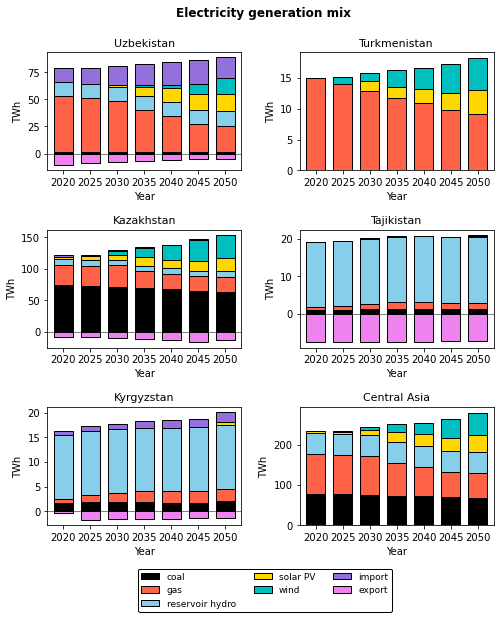

In [19]:
# Visualizing the results
yearly_plot(scen_re, path, "activity")

Now, we add the same renewable share to a scenario with SPHS.

In [20]:
# Cloning a baseline scenario with SPHS for adding renewable shares
sphs_re = sphs.clone(scenario="renewable_policy_sphs", keep_solution=False)
sphs_re.check_out()

Existing index sets of 'map_tec_storage' ['node', 'technology', 'mode', 'storage_tec', 'mode', 'level', 'commodity', 'lvl_temporal'] do not match ['node', 'technology', 'mode', 'technology', 'mode', 'level', 'commodity', 'lvl_temporal']
Existing index sets of 'STORAGE' ['node', 'technology', 'level', 'commodity', 'year', 'time'] do not match ('node', 'technology', 'mode', 'level', 'commodity', 'year', 'time')


In [21]:
# Adding the share for renewables
add_share_activity(sphs_re,
                   relation,            # A relation name
                   tec_share,             # Technologies formig the share (nominator)
                   tec_total,             # Technologies formig the total (denominator)
                   shares,                # A dictionary of shares per year
                   regions,               # Regions for applying the share
                  )

In [22]:
# Saving changes and solving the scenario
sphs_re.commit("changes saved!")
sphs_re.solve(solve_options={'lpmethod': '4'})

In [ ]:
# Comparing three scenarios on total system costs and GHGs
compare_three_scenario(base, scen_re, sphs_re,
                           scenario_names=["Baseline", "High RE without SPHS", "High RE with SPHS"],
                           )

## 4. Adding emissions targets
Emissions targets can be modeled in `message_ix` using the parameter `bound_emission`. The emissions bound can be added for a certain type of technologies, like powerplants, or for all technologies. In this section, we add total carbon emissions (TCE) bound and investigate the impact on the electricity sector.

### 4.1 Emissions reduction target
Emissions targets are usually set as a % reduction relative to a certain year, e.g., 1990 or 2010. In this example, we add a total carbon emissions target in 2050, representing 40% reduction compared to 2020 as the reference year. We derive the reference carbon emissions from the Baseline scenario.

In [24]:
# Cloning a scenario for adding emissions targets
emis = base.clone(scenario="emission_policy", keep_solution=False)
emis.check_out()

Existing index sets of 'map_tec_storage' ['node', 'technology', 'mode', 'storage_tec', 'mode', 'level', 'commodity', 'lvl_temporal'] do not match ['node', 'technology', 'mode', 'technology', 'mode', 'level', 'commodity', 'lvl_temporal']
Existing index sets of 'STORAGE' ['node', 'technology', 'level', 'commodity', 'year', 'time'] do not match ('node', 'technology', 'mode', 'level', 'commodity', 'year', 'time')


In [25]:
# Retrieving total carbon emissions (TCE) of Central Asia (CAS) from Baseline
node = ["CAS"]       # Central Asia 
tce = base.var("EMISS", {"node": node, "emission": "TCE", "type_tec": "all"})
tce

,node,emission,type_tec,year,lvl,mrg
0,CAS,TCE,all,2020,100.883118,0.0
1,CAS,TCE,all,2025,76.611255,0.0
2,CAS,TCE,all,2030,79.763679,0.0
3,CAS,TCE,all,2035,76.409040,0.0
4,CAS,TCE,all,2040,75.349087,0.0
5,CAS,TCE,all,2045,79.283657,0.0
6,CAS,TCE,all,2050,77.856555,0.0
7,CAS,TCE,all,2055,78.069895,0.0
8,CAS,TCE,all,2060,71.581969,0.0


In [26]:
# Using TCE emissions of 2020 as the reference for 40% reduction by 2050
ref = float(tce.loc[tce["year"] == 2020]["lvl"])
target = ref * (1 - 0.4)

### 4.2 Adding new carbon emissions target
It should be noted that the unit of carbon emissions is in MtC-eq. These emissions include those from fossil fuel upstream supply chain, refineries, and the power sector. Land use emissions and emissions form the industry and heating/cooling are not included here.

In [27]:
# Adding total carbon emissions (TCE) target for Central Asia in 2050
mp.add_unit("MtC")    # adding the unit to the platform (if not exists)
emis.add_par("bound_emission", ["CAS", "TCE", "all", 2050], target, "MtC")

In [28]:
# Saving changes and solving the scenario
emis.commit("changes saved!")
emis.solve(solve_options={'lpmethod': '4'})

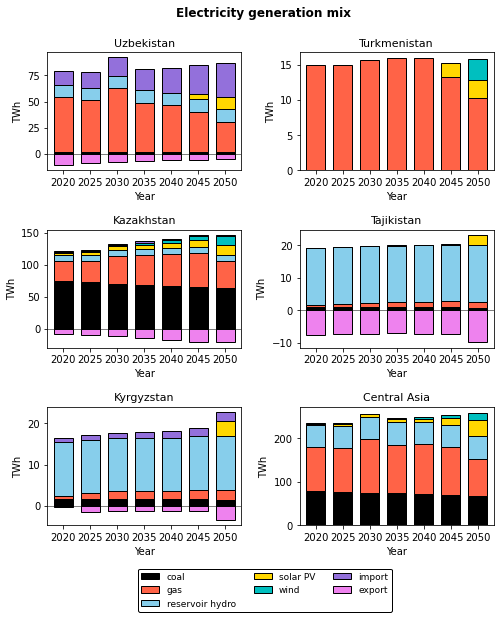

In [29]:
# Visualizing the results
yearly_plot(emis, path, "activity")

In [ ]:
# Comparing three scenarios on total system costs and GHGs
compare_three_scenario(base, scen_re, emis,
                           scenario_names=["Baseline", "High RE without SPHS", "Low emission"],
                           )

#### Exercise:
You can clone a scenario from `sphs` and add an emission target to it as shown above. Then, compare with the same emission target added to `Baseline` scenario. How has pumpedhydro storage (SPHS) helped the system?

In [ ]:
# Close the databse at the end of your work
mp.close_db()